# Data exploration in the PSA with EPN-TAP
- EPN-TAP is a Europlanet extension of TAP for planetary science
- The PSA supports access to products via EPN-TAP
  - EPN-TAP allows queries to the database not possible with other interfaces
- The PSA TAP database offers a _catalogue_ of data products, not the data themselves
- Data in the PSA are archived in [PDS](https://pds.nasa.gov/) format
    - each archive item consists of product + label
        - PDS3 = previous standard (labels in PVL)
        - PDS4 = current standard (labels in XML)
- PSA data are highly diverse
    - from microscope to telescopes
    - on orbiters, flyby missions, landers etc.
- The PSA supports versioning of products/datasets and private data
    - PSA EPN-TAP shows only the latest version
    - Meta-data for private data are shown, but no detailed info
        - so calculations of product _size_ apply only to public data, for example
- EPN-TAP indexes __only__ the data/observational products
    - not calibration files, documents, ancillary products etc.

In [2]:
import zipfile, struct, warnings, requests, struct, os
from pathlib import PurePath
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import astropy, skimage
from astropy.io.votable import parse_single_table
from astroquery.utils.tap.core import Tap
import pvl

from pds4_tools import read

import IPython.display as display
from PIL import Image

%matplotlib inline
warnings.simplefilter('ignore')

Point the astroquery TAP library to the PSA EPN-TAP server

In [3]:
tap_url = 'https://archives.esac.esa.int/psa/epn-tap/tap/'
psa = Tap(url=tap_url)

def query(q):
    return(psa.launch_job(q).get_data())

## PSA data exploration

Run some simple queries to get some statistics about the data in the PSA

### How many products are there in the archive?

In [4]:
result = query('SELECT COUNT(1) from epn_core')
result['count'][0]

9557830

## How many products are there per mission?

In [5]:
 query('SELECT instrument_host_name, count(*) as num_prod FROM epn_core GROUP BY instrument_host_name ORDER BY num_prod DESC')

instrument_host_name,num_prod
object,int64
Rosetta,6451823
ExoMars 2016,985310
Mars Express,895973
SMART-1,604527
Venus Express,603584
Huygens,7669
BepiColombo,4699
Giotto,2129
Ground Based,2083


## And how *much* data (in TB)?

In [6]:
result = query('SELECT SUM(access_estsize) from epn_core') # in kbyte
print('Size of latest versions of public data: {:3.2f} TB'.format(result['sum'][0]/1024.**3))

Size of latest versions of public data: 53.09 TB


## What are the biggest products?

In [7]:
query('SELECT TOP 10 granule_uid, access_estsize from epn_core WHERE access_estsize IS NOT NULL ORDER BY access_estsize DESC')

granule_uid,access_estsize
object,int32
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H0143_0009_ND3.IMG,13991351
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1582_0000_ND3.IMG,9698451
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1550_0000_ND3.IMG,7671650
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1572_0000_ND3.IMG,7650967
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1574_0008_ND3.IMG,7441475
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1566_0000_ND3.IMG,7084002
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1532_0000_ND3.IMG,7039434
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1526_0000_ND3.IMG,6972087
MEX-M-HRSC-5-REFDR-MAPPROJECTED-V3.0:DATA:H1545_0000_ND3.IMG,6919250


## Which mission has the most data?

In [8]:
query('SELECT instrument_host_name, sum(access_estsize)/1024./1024. as prod_size from epn_core WHERE access_estsize IS NOT NULL GROUP BY instrument_host_name ORDER BY prod_size DESC')

instrument_host_name,prod_size
object,float64
Rosetta,25262.172539711
Mars Express,23602.943000793457
Venus Express,5117.194445610046
SMART-1,285.4755525588989
Ground Based,71.46468544006348
ExoMars 2016,19.6166934967041
Huygens,5.611635208129883
BepiColombo,1.0384464263916016
Giotto,0.3721170425415039


Wow, so the top two missions account for almost all of the data in the archive:

### How many different targets are there in the archive?

In [9]:
query('SELECT DISTINCT target_name FROM epn_core')

target_name
object
Lutetia
Earth
1P
Venus
9P
Mercury
Moon
67P
Jupiter


## OK, what data do we have about Mars - show me the missions!

In [10]:
query("SELECT DISTINCT instrument_host_name FROM epn_core WHERE target_name='Mars'")

instrument_host_name
object
ExoMars 2016
Rosetta
Venus Express
Mars Express


## Interesting - Rosetta observed Mars! With which instruments?

In [11]:
query("SELECT DISTINCT instrument_name FROM epn_core WHERE target_name='Mars' AND instrument_host_name='Rosetta'")

instrument_name
object
OSIRIS
VIRTIS
RSI
NAVCAM
COSAC
SESAME
RPC
CONSERT
ALICE


## OSIRIS is the camera, right? What data did it produce?

In [12]:
osiris_mars = query("SELECT * FROM epn_core WHERE target_name='Mars' AND instrument_name='OSIRIS'")
len(osiris_mars)

60

In [13]:
osiris_mars.colnames

['access_estsize',
 'access_format',
 'access_url',
 'c1max',
 'c1min',
 'c1_resol_max',
 'c1_resol_min',
 'c2max',
 'c2min',
 'c2_resol_max',
 'c2_resol_min',
 'c3max',
 'c3min',
 'c3_resol_max',
 'c3_resol_min',
 'creation_date',
 'dataproduct_type',
 'emergence_max',
 'emergence_min',
 'granule_gid',
 'granule_uid',
 'incidence_max',
 'incidence_min',
 'instrument_host_name',
 'instrument_name',
 'measurement_type',
 'modification_date',
 'obs_id',
 'phase_max',
 'phase_min',
 'processing_level',
 'release_date',
 'service_title',
 'spatial_frame_type',
 'spectral_range_max',
 'spectral_range_min',
 'spectral_resolution_max',
 'spectral_resolution_min',
 'spectral_sampling_step_max',
 'spectral_sampling_step_min',
 's_region',
 'target_class',
 'target_name',
 'thumbnail_url',
 'time_exp_max',
 'time_exp_min',
 'time_max',
 'time_min',
 'time_sampling_step_max',
 'time_sampling_step_min']

In [14]:
osiris_mars[0]

access_estsize,access_format,access_url,c1max,c1min,c1_resol_max,c1_resol_min,c2max,c2min,c2_resol_max,c2_resol_min,c3max,c3min,c3_resol_max,c3_resol_min,creation_date,dataproduct_type,emergence_max,emergence_min,granule_gid,granule_uid,incidence_max,incidence_min,instrument_host_name,instrument_name,measurement_type,modification_date,obs_id,phase_max,phase_min,processing_level,release_date,service_title,spatial_frame_type,spectral_range_max,spectral_range_min,spectral_resolution_max,spectral_resolution_min,spectral_sampling_step_max,spectral_sampling_step_min,s_region,target_class,target_name,thumbnail_url,time_exp_max,time_exp_min,time_max,time_min,time_sampling_step_max,time_sampling_step_min
,,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,,,deg,deg,,,deg,deg,,,,,,deg,deg,,,,,Hz,Hz,Hz,Hz,Hz,Hz,,,,,s,s,d,d,s,s
int32,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,object,float64,float64,object,object,object,object,object,float64,float64,int32,object,object,object,float64,float64,float64,float64,float64,float64,object,object,object,object,float64,float64,float64,float64,float64,float64
2121,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA:N20070224T183409631ID20F82,--,--,--,--,--,--,--,--,--,--,--,--,2019-11-18T01:03:52.284878,ci,--,--,RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA,RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA:N20070224T183409631ID20F82,--,--,Rosetta,OSIRIS,,2019-11-18T01:03:52.284878,RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA:N20070224T183409631ID20F82,--,--,3,2011-04-13T00:00:00.0,psa,none,--,--,--,--,--,--,,planet,Mars,https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4/BROWSE/2007_02/N20070224T183409631ID20F82.JPG,--,--,2454156.2738028937,2454156.2738025463,--,--


## Let's just tidy that up a bit

- Putting the table into pandas since I'm more comfortable with it
- There are lots of columns with "Nan"s because not all fields can be (easily) populated due to the diverse nature of the instruments
    - remove those 
- convert Julian times into readable timestamps
- resulting function: query_pandas(query)

In [15]:
def query_pandas(q):
    df = query(q).to_pandas()
    df.dropna(axis=1, how='all', inplace=True)
    str_df = df.select_dtypes([np.object])
    if not str_df.empty:
        str_df = str_df.stack().str.decode('utf-8').unstack()
        for col in str_df:
            df[col] = str_df[col]        
    df['time_min'] = pd.to_datetime(df['time_min'], origin='julian', unit='D') 
    df['time_max'] = pd.to_datetime(df['time_max'], origin='julian', unit='D') 
    return df

In [16]:
osiris_mars = query_pandas("SELECT * FROM epn_core WHERE target_name='Mars' AND instrument_name='OSIRIS'")

Now we have all of the fields that have populated values in this query - let's look at the first row:

In [17]:
osiris_mars.iloc[0]

access_estsize                                                       2121
access_format                                       application/x-pds-zip
access_url              https://archives.esac.esa.int/psa/pdap/downloa...
creation_date                                  2019-11-18T01:03:52.284878
dataproduct_type                                                       ci
granule_gid                      RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA
granule_uid             RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA:N2007...
instrument_host_name                                              Rosetta
instrument_name                                                    OSIRIS
measurement_type                                                         
modification_date                              2019-11-18T01:03:52.284878
obs_id                  RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA:N2007...
processing_level                                                        3
release_date                          

Ahh, thumbnails are provided!

Great, I don't have to work hard to get a sneak preview! Let's look at an example - we can show images directly in the Notebook:

In [18]:
osiris_mars.iloc[0].thumbnail_url

'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4/BROWSE/2007_02/N20070224T183409631ID20F82.JPG'

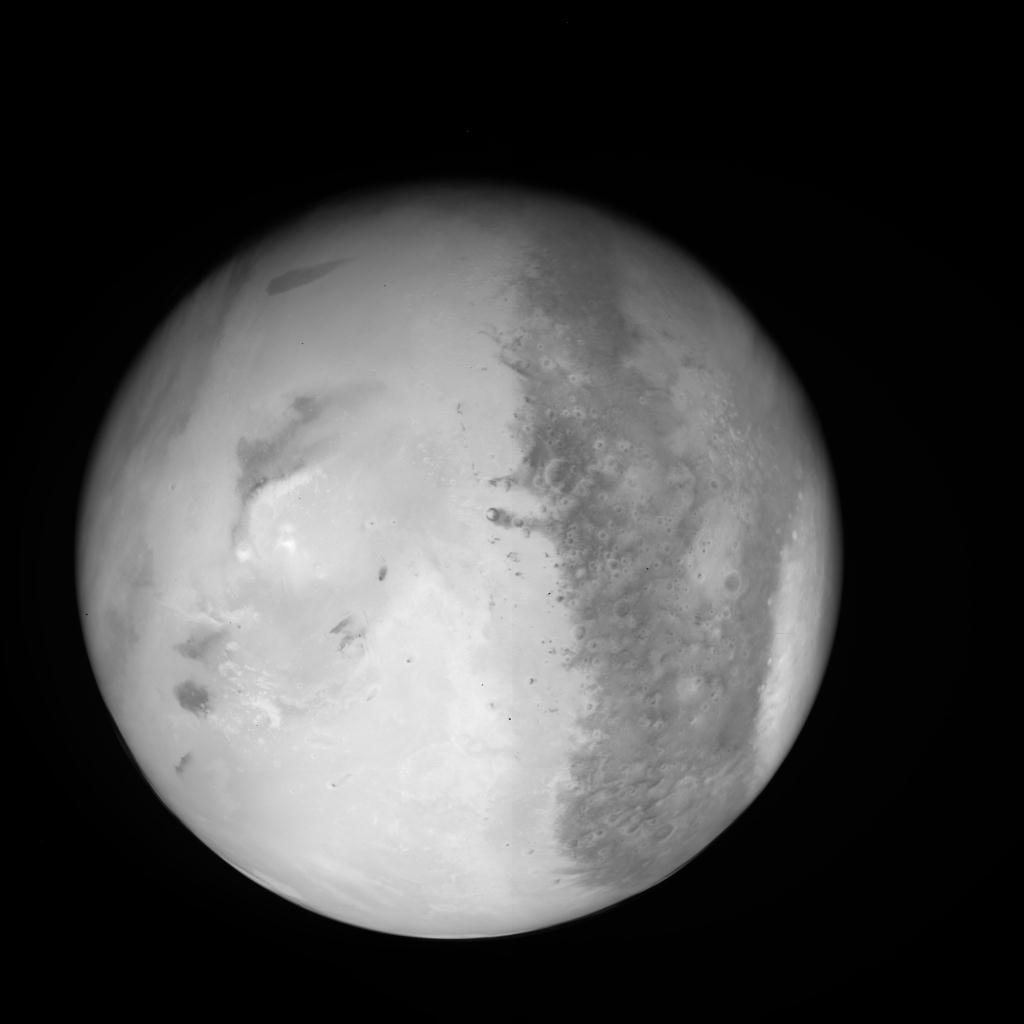

In [19]:
display.Image(osiris_mars.thumbnail_url.iloc[0], width=500, embed=True)

We can also grab a bunch of images and show them using matplotlib (easier to tile etc.). Let's take the first 9:

## Let's get the _real_ data for that image

I have a URL for direct access, and a format - which the MIME code tell me is a zip.

In [20]:
access_url = osiris_mars.iloc[0].access_url
access_url

'https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4:DATA:N20070224T183409631ID20F82'

Let's download the zip on the fly and see what's in it...

In [21]:
r = requests.get(url=access_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zipfiles = zip.namelist()
zipfiles

['RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4/BROWSE/2007_02/N20070224T183409631ID20F82.LBL',
 'RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4/DATA/2007_02/N20070224T183409631ID20F82.IMG',
 'RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4/BROWSE/2007_02/N20070224T183409631ID20F82.JPG',
 'inventory.txt']

So the product actually consists of the image file with attached label, and a browse product. We need to get the file in the DATA directory to work with the actual data...


In [22]:
data_file = [file for file in zipfiles[:-1] if PurePath(file).parts[1]=='DATA'][0]
data_file

'RO-M-OSINAC-2-MARS-MARSSWINGBY-V1.4/DATA/2007_02/N20070224T183409631ID20F82.IMG'

Ooh, attached PDS3 labels are nasty - I picked a bad example! Still, we can deal with it - find the label length by parsing until we hit "END" in function read_label()

In [23]:
def read_label(data_file):
    label = []
    with zip.open(data_file) as f:  
        line = f.readline().decode('utf8')
        while line.strip() != 'END':
            if line.strip() == '':
                line = f.readline().decode('utf8')
                continue
            else:
                label.append(line.strip())
                line = f.readline().decode('utf8')
            
    return '\r\n'.join(label)

In [24]:
label = read_label(data_file)

PDS3 labels are stored in "Parameter Value Language" (PVL) which we can pass to get a dictionary...

In [25]:
meta = pvl.loads(label)
meta

PVLModule([
  ('PDS_VERSION_ID', 'PDS3')
  ('LABEL_REVISION_NOTE', 'V3k Apr 4 2011 SFH - $Rev: 537 $')
  ('RECORD_TYPE', 'FIXED_LENGTH')
  ('RECORD_BYTES', 512)
  ('FILE_RECORDS', 4155)
  ('LABEL_RECORDS', 42)
  ('FILE_NAME', 'N20070224T183409631ID20F82.IMG')
  ('^HISTORY', 43)
  ('^IMAGE', 56)
  ('^PA_IMAGE', 4152)
  ('^PB_IMAGE', 4154)
  ('^BLADE1_PULSE_ARRAY', 48)
  ('^BLADE2_PULSE_ARRAY', 52)
  ('PROCESSING_HISTORY_TEXT', 'Level 1 PDS file created - tmi2pds 2011-04-04')
  ('SOFTWARE_DESC', 'Osiris level 1 PDS file generator')
  ('SOFTWARE_NAME', 'tmi2pds.exe')
  ('SOFTWARE_VERSION_ID', 'V3.0.0.10')
  ('SOFTWARE_RELEASE_DATE', datetime.date(2011, 4, 4))
  ('INSTRUMENT_HOST_ID', 'RO')
  ('INSTRUMENT_HOST_NAME', 'ROSETTA-ORBITER')
  ('MISSION_ID', 'ROSETTA')
  ('MISSION_NAME', 'INTERNATIONAL ROSETTA MISSION')
  ('MISSION_PHASE_NAME', 'MARS SWING-BY')
  ('INSTRUMENT_ID', 'OSINAC')
  ('INSTRUMENT_NAME', 'OSIRIS - NARROW ANGLE CAMERA')
  ('INSTRUMENT_TYPE', 'FRAME CCD REFLECTING TELESCOP

Oof, that's a lot of meta-data! Now we have all of the PDS3 meta-data ready to be used. We can use the IMAGE pointer to tell us where to get the actual image array

In [26]:
offset = (meta['^IMAGE']-1) * meta['RECORD_BYTES']
offset

28160

But we need a bit more meta-data to open it correctly...

In [27]:
meta['IMAGE']

PVLObject([
  ('BANDS', 1)
  ('FIRST_LINE', 1)
  ('FIRST_LINE_SAMPLE', 1)
  ('INTERCHANGE_FORMAT', 'BINARY')
  ('LINES', 1024)
  ('LINE_SAMPLES', 1024)
  ('SAMPLE_BITS', 16)
  ('SAMPLE_TYPE', 'LSB_UNSIGNED_INTEGER')
  ('DERIVED_MINIMUM', 192.0)
  ('DERIVED_MAXIMUM', 31038.0)
  ('MEAN', 8473.167903)
])

In [28]:
rows = meta['IMAGE']['LINES']
cols = meta['IMAGE']['LINE_SAMPLES']
samples = rows * cols

OK, how we have enough to unpack the data!

In [29]:
data = struct.unpack_from('<%dH' % samples, zip.open(data_file).read(), offset)
data = np.array(data).reshape((cols, rows))

and plot them:

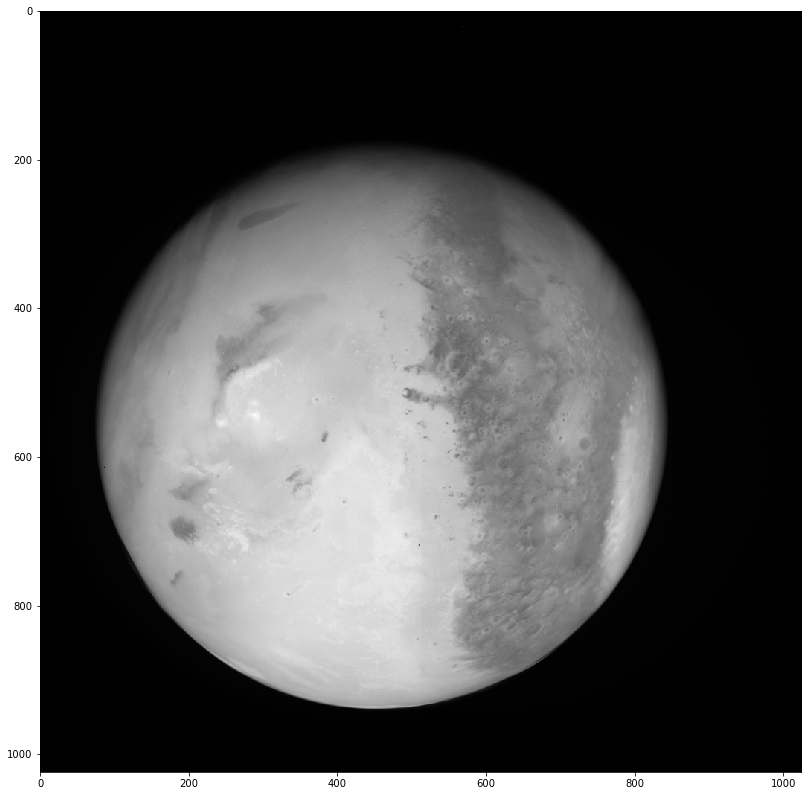

In [30]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(data, cmap=matplotlib.cm.gray, interpolation='nearest')

Check the minimum, maximum and mean values to compare with the label:

In [31]:
meta['IMAGE']['DERIVED_MINIMUM'], meta['IMAGE']['DERIVED_MAXIMUM'], meta['IMAGE']['MEAN']

(192.0, 31038.0, 8473.167903)

In [32]:
data.min(), data.max(), data.mean()

(192, 31038, 8473.167902946472)

Now we have the real data, not just a preview, and can try things like histograms

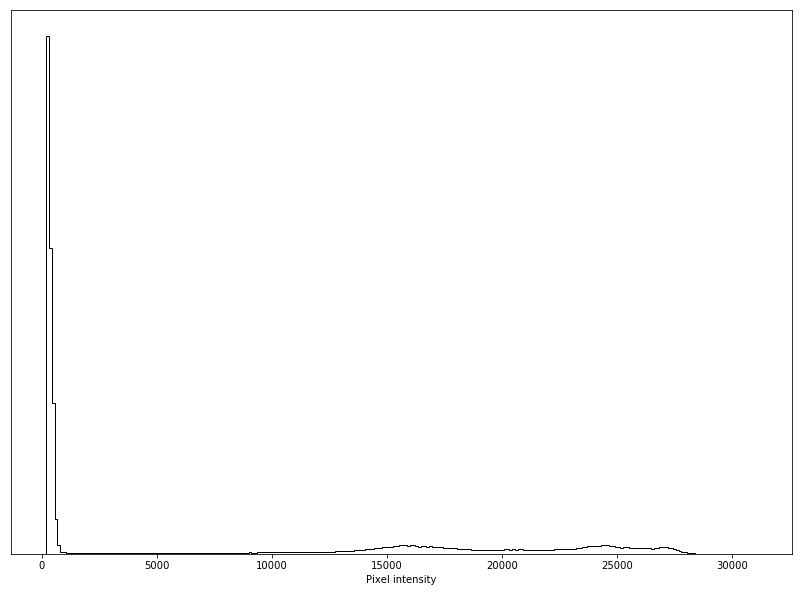

In [33]:
fig_hist, ax_hist = plt.subplots(figsize=(14,10))
ax_hist.hist(data.ravel(), bins=256, histtype='step', color='black')
ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax_hist.set_xlabel('Pixel intensity')
ax_hist.set_yticks([]);

Now we can play with things like adaptive histogram equalisation:

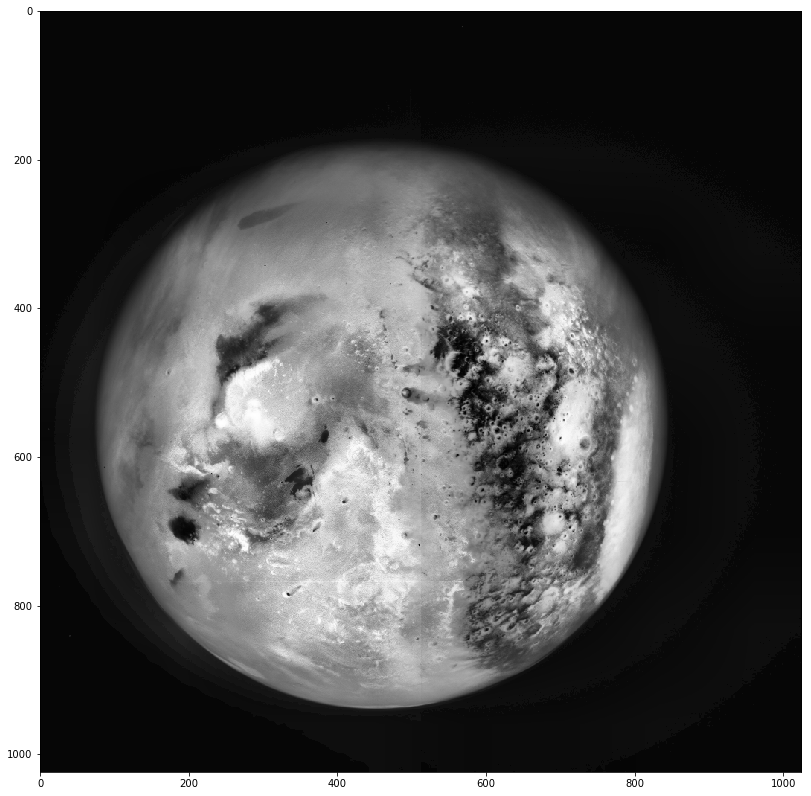

In [34]:
img_adapteq = skimage.exposure.equalize_adapthist(data, clip_limit=0.03)
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(img_adapteq, cmap=matplotlib.cm.gray, interpolation='nearest')

# PDS4

Can we check if a data product is PDS3 or PDS4 in advance? Kind of... The granule_gid for PDS4 products will always start "urn:esa:psa" - this is the prefix of the LID (logical identifier) in PDS4. For PDS3 this attribute will start with the dataset name. Let's see which missions produce which data type:

In [35]:
query("SELECT DISTINCT instrument_host_name from epn_core WHERE granule_gid LIKE 'urn:esa:psa:%'")

instrument_host_name
object
ExoMars 2016
BepiColombo


In [36]:
query("SELECT DISTINCT instrument_host_name from epn_core WHERE granule_gid NOT LIKE 'urn:esa:psa:%'")

instrument_host_name
object
Huygens
Venus Express
Mars Express
Giotto
Ground Based
Hubble
SMART-1
Rosetta


PDS4 data are easier to work with since we have nice tools that work on all valid products. Let's see if BepiColombo has any public data - we can check if data are public by seeing if they have a download URL:

In [37]:
query("SELECT DISTINCT instrument_name from epn_core WHERE instrument_host_name='BepiColombo' and access_url IS NOT NULL")

instrument_name
object
MCAM


OK, the monitoring camera has public data - let's take a look!

In [38]:
mcam = query_pandas("SELECT * from epn_core WHERE instrument_name='MCAM' and access_url IS NOT NULL")
len(mcam)

525

In [39]:
mcam.iloc[-1]

access_estsize                                                       2077
access_format                                       application/x-pds-zip
access_url              https://archives.esac.esa.int/psa/pdap/downloa...
creation_date                                  2019-11-18T01:03:52.284878
dataproduct_type                                                       ci
granule_gid                              urn:esa:psa:bc_mtm_mcam:data_raw
granule_uid             urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...
instrument_host_name                                          BepiColombo
instrument_name                                                      MCAM
measurement_type                                                         
modification_date                              2019-11-18T01:03:52.284878
obs_id                  urn:esa:psa:bc_mtm_mcam:data_raw:cam_raw_sc_ca...
processing_level                                                        2
release_date                          

BepiColombo is using the PSA as an "operational" archive, and the MCAM data are made public ~a week after they hit the ground, so the last public data are only ~10 days old...

In [40]:
r = requests.get(url=mcam.iloc[-1].access_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zipfiles = zip.namelist()
zipfiles

['bc_mtm_mcam/data_raw/cruise/201911/cam_raw_sc_cam3_image_20191107t042450_62_f__t0020.xml',
 'bc_mtm_mcam/data_raw/cruise/201911/cam_raw_sc_cam3_image_20191107t042450_62_f__t0020.fits',
 'bc_mtm_mcam/browse/cruise/201911/cam_raw_sc_cam3_browse_20191107t042450_62_f__t0020.xml',
 'bc_mtm_mcam/browse/cruise/201911/cam_raw_sc_cam3_browse_20191107t042450_62_f__t0020.jpeg',
 'bc_mtm_mcam/bundle_bc_mtm_mcam.xml',
 'bc_mtm_mcam/data_raw/collection_data_raw.xml',
 'bc_mtm_mcam/data_raw/collection_data_raw.csv',
 'inventory.txt']

Here we get the browse image, and a FITS file with the data. We could access this with a FITS library, but since it is fully described by a PDS4 label, we can also use a PDS4 viewer, which would work on _any_ PDS4 product. Reading only the fly is a bit messy, so here I will just extract the files locally:

In [61]:
zip.extract(zipfiles[0])
zip.extract(zipfiles[1])

'/home/mbentley/Dropbox/notebooks/bc_mtm_mcam/data_raw/cruise/201911/cam_raw_sc_cam3_image_20191107t042450_62_f__t0020.fits'

Point the PDS4 reader at the label and you will get all of the data structures returned:

In [63]:
mcam_data = read(zipfiles[0])

Processing label: bc_mtm_mcam/data_raw/cruise/201911/cam_raw_sc_cam3_image_20191107t042450_62_f__t0020.xml
Now processing a Header structure: FITS header
Now processing a Array_2D_Image structure: MCAM_image


In [64]:
mcam_data.info()

0   Header          'FITS header'  FITS 3.0
1   Array_2D_Image  'MCAM_image'   2 axes, 1024 x 1024


Now we can simply plot the data from the Array_2D_Image structure:

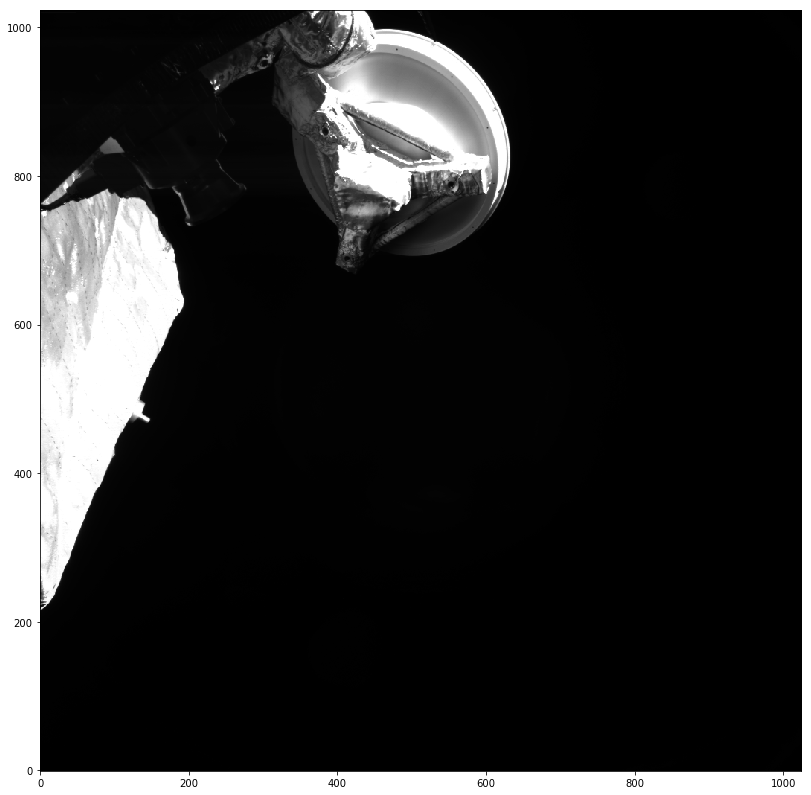

In [68]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(mcam_data['MCAM_image'].data, cmap=matplotlib.cm.gray, interpolation='nearest', origin='top')